In [3]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [4]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [5]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [148]:
kharpov = True

In [306]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -4.45,
                   'log_scale': -3.48,
                   'logit_rho': 1.21,
                   'phi': -0.01,
                    'pi': -22.7, 
                   'theta': 0.28}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2_000
sim_dim = 250
innov_dim = 250

In [307]:
bounds = {'pi': {'max': 0, 'min':-25, 'dim':32}, 'phi': {'max': -.2, 'min':-.5, 'dim':4}, 
          'theta': {'max':2.5, 'min': 0, 'dim':12}}

In [308]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [309]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [310]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.02034864625098453,
 'return_var': 0.017873157660876243,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [311]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [312]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.011966,0.015352
std,0.013983,0.103644
min,0.000010,-0.507374
25%,0.002204,-0.028467
50%,0.006976,0.018886
75%,0.016485,0.062348
max,0.095437,0.891799


In [313]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [314]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [315]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

## We start by examining the distributions of simulated data

In [316]:
data.corr()

,vol,rtn
vol,1.000000,-0.118286
rtn,-0.118286,1.000000


In [317]:
data.head()

,vol,rtn
2000-01-01,0.005296,0.094594
2000-01-02,0.007394,-0.025605
2000-01-03,0.001382,0.080647
2000-01-04,0.000596,0.001493
2000-01-05,0.001920,0.081101


In [318]:
data.var()

vol    0.000196
rtn    0.010742
dtype: float64

In [319]:
vl.compute_vol_gmm(data.vol)

({'log_both': -5.934467139179028,
  'log_scale': -5.551091089493258,
  'logit_rho': 1.2444515266481262},
            log_both  log_scale  logit_rho
 log_both   0.004973   0.000830  -0.005091
 log_scale  0.000830   0.001475  -0.000316
 logit_rho -0.005091  -0.000316   0.013906)

In [320]:
omega, omega_cov = vl.estimate_params(data)

In [321]:
total_est, total_cov = vl.estimate_params_strong_id(data, bounds=bounds)

In [322]:
omega

{'gamma': 0.012573375574627142,
 'beta': 3.926575397336702,
 'psi': -3.696130178305947,
 'zeta': 0.7871100697385425,
 'log_both': -5.934467139179028,
 'log_scale': -5.551091089493258,
 'logit_rho': 1.2444515266481262}

In [323]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.013335,-3.911426e-05,0.000000,0.000000,0.000000,-0.010061,0.000000
gamma,-0.000039,3.145149e-07,0.000000,0.000000,0.000000,0.000013,0.000000
log_both,0.000000,0.000000e+00,0.004973,0.000830,-0.005091,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.000830,0.001475,-0.000316,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.005091,-0.000316,0.013906,0.000000,0.000000
psi,-0.010061,1.282204e-05,0.000000,0.000000,0.000000,0.041931,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000658


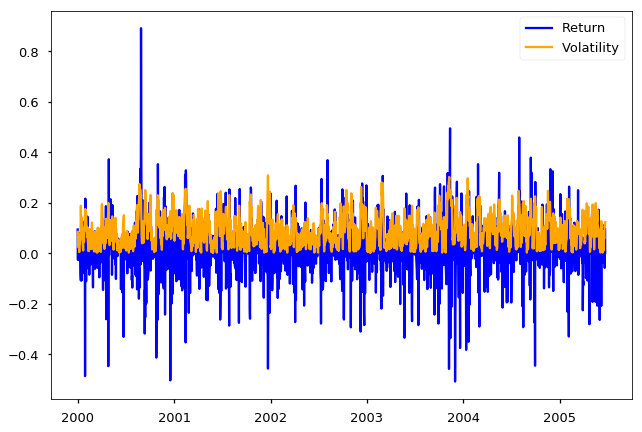

In [324]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [325]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.003427,-0.000663
rtn,-0.000663,0.010742


In [326]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

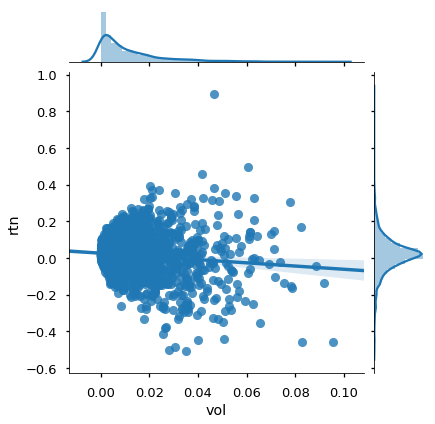

In [327]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [328]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.011966,0.015352
std,0.013983,0.103644
min,0.000010,-0.507374
25%,0.002204,-0.028467
50%,0.006976,0.018886
75%,0.016485,0.062348
max,0.095437,0.891799


## I now estimate all of the parameters

In [329]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [330]:
vl.compute_init_constants(data.vol)

{'log_both': -5.894922669938428,
 'log_scale': -5.585811950066299,
 'logit_rho': 1.2099715970824354}

In [331]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [332]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -5.925854176223757,
  'log_scale': -5.4664926613909595,
  'logit_rho': 1.2933428159049658},
            log_both  log_scale  logit_rho
 log_both   0.005994   0.000700  -0.007728
 log_scale  0.000700   0.002582   0.000210
 logit_rho -0.007728   0.000210   0.020598)

In [333]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [334]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [335]:
estimator(data_arr[0])

({'gamma': 0.011614154109176688,
  'beta': 4.062687453505623,
  'psi': -3.6022451309680616,
  'zeta': 0.8031215138039196,
  'log_both': -5.925854176223757,
  'log_scale': -5.4664926613909595,
  'logit_rho': 1.2933428159049658,
  'phi': -0.43319378970351646,
  'pi': -0.16961279889088482,
  'theta': 1.92810117584655},
                beta         gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.018488 -4.100708e-05  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000041  2.711994e-07  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000e+00  0.005994   0.000700  -0.007728       NaN   
 log_scale  0.000000  0.000000e+00  0.000700   0.002582   0.000210       NaN   
 logit_rho  0.000000  0.000000e+00 -0.007728   0.000210   0.020598       NaN   
 phi             NaN           NaN       NaN        NaN        NaN  0.000861   
 pi              NaN           NaN       NaN        NaN        NaN -0.286981   
 psi       -0.015168  1.906966e-05  0.0000

In [336]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [337]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [338]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [339]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta', 'psi']

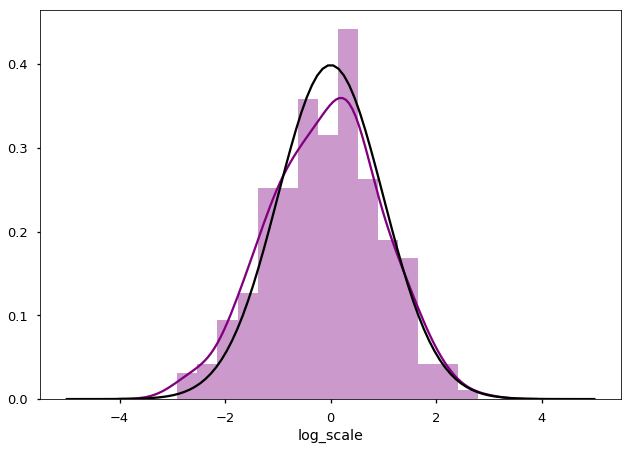

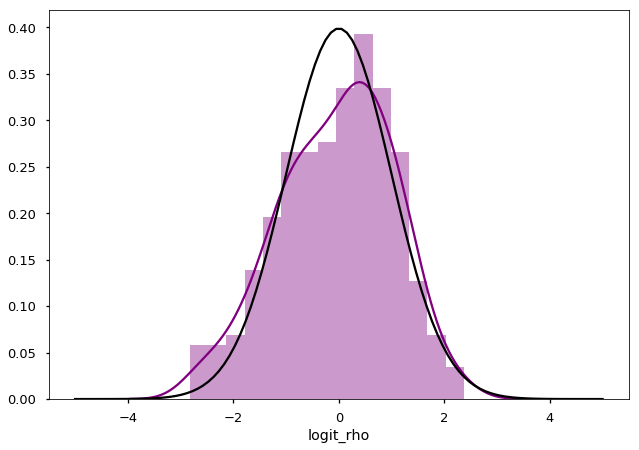

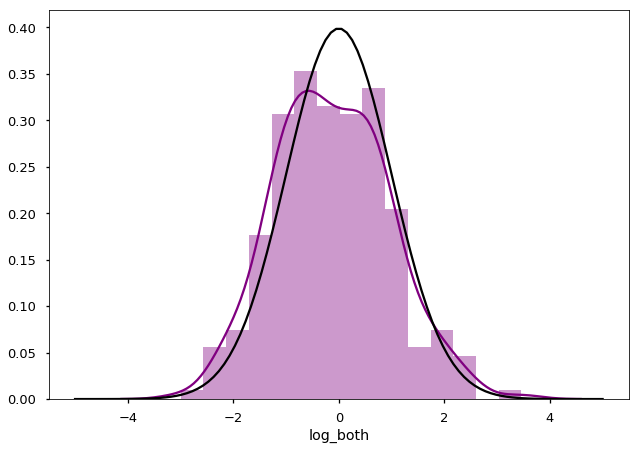

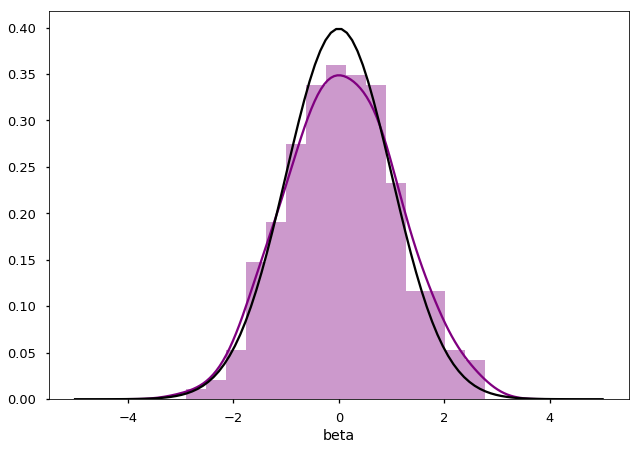

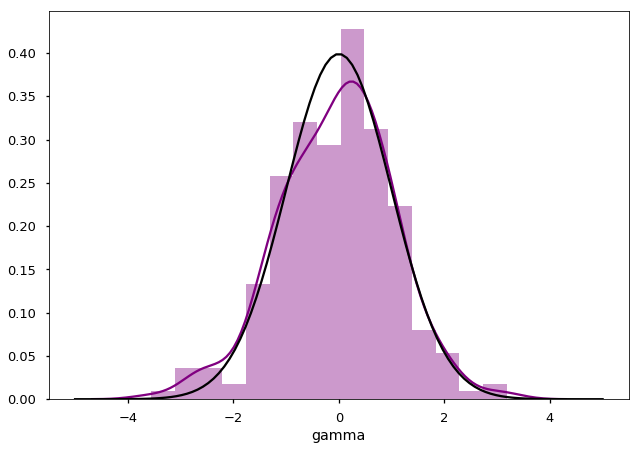

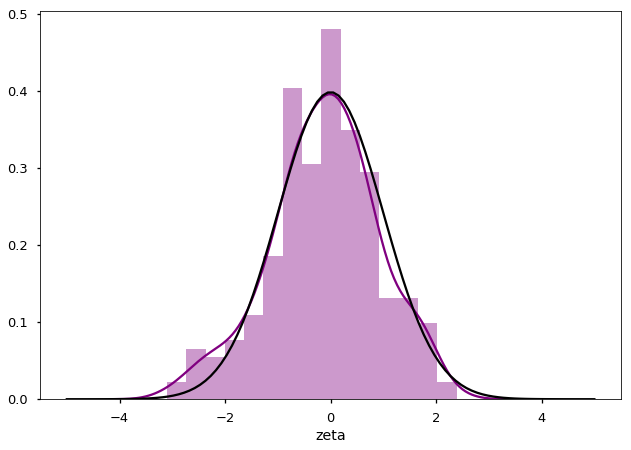

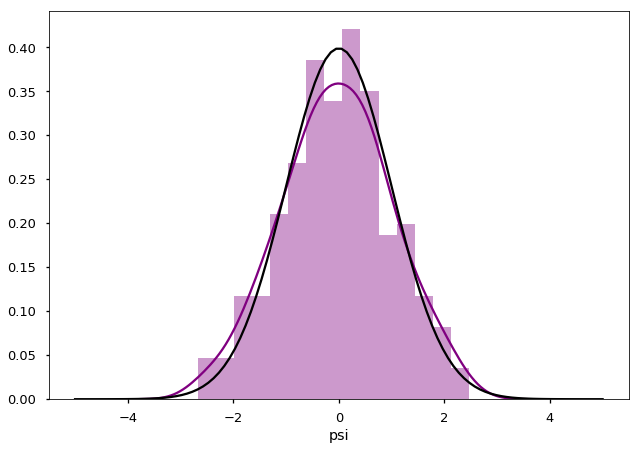

In [340]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [341]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [342]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

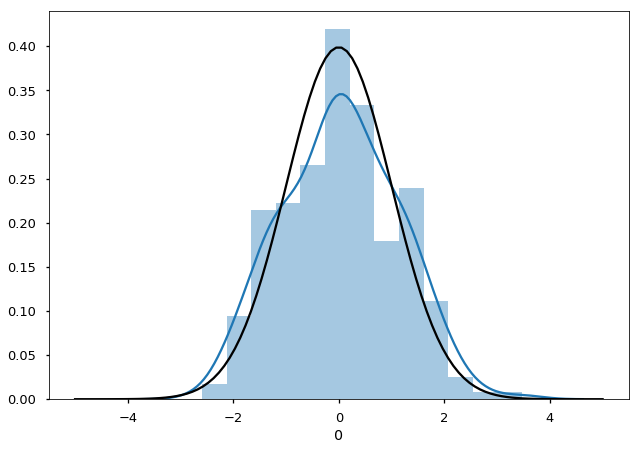

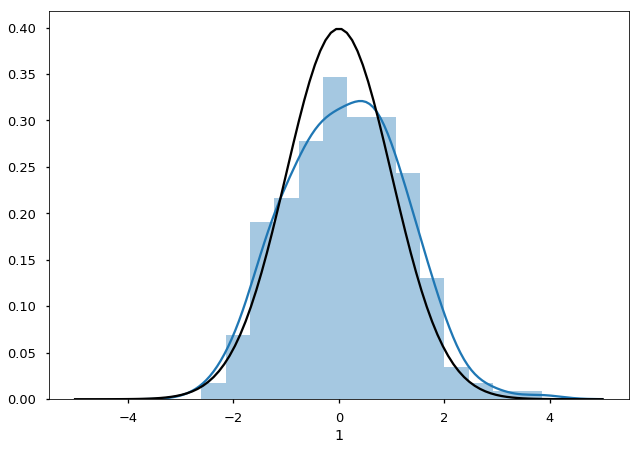

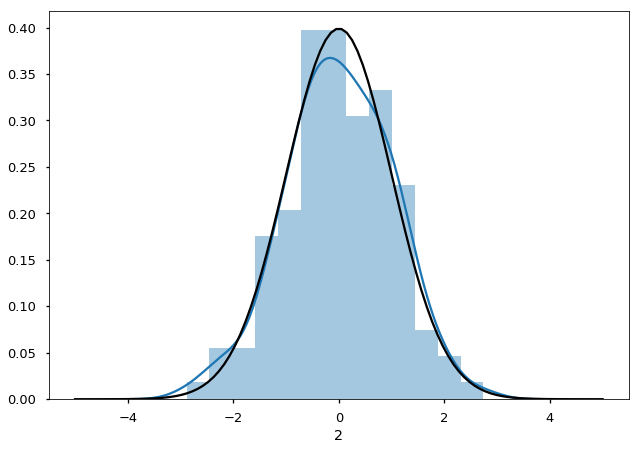

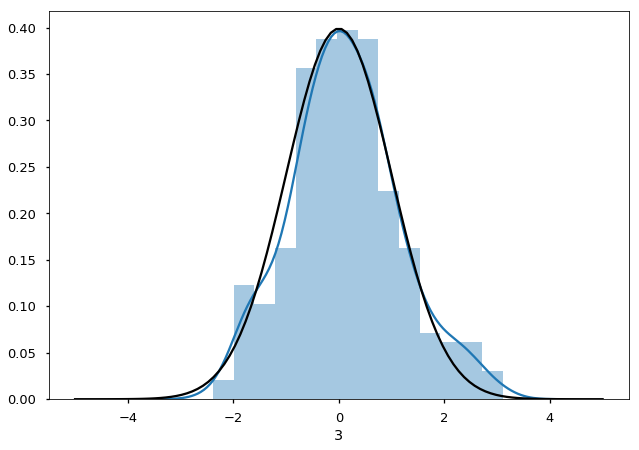

In [343]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

In [344]:
bounds

{'pi': {'max': 0, 'min': -25, 'dim': 32},
 'phi': {'max': -0.2, 'min': -0.5, 'dim': 4},
 'theta': {'max': 2.5, 'min': 0, 'dim': 12}}

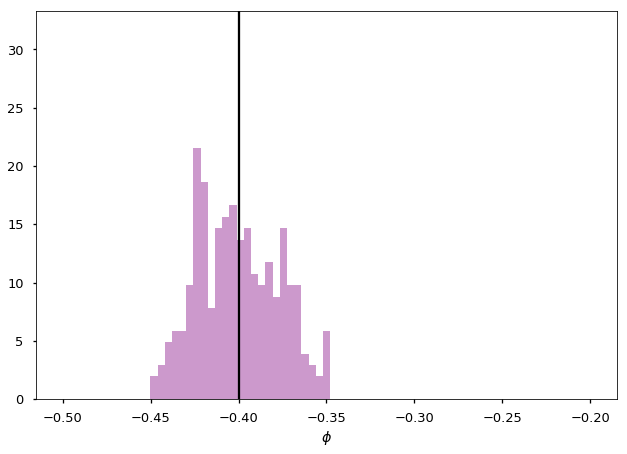

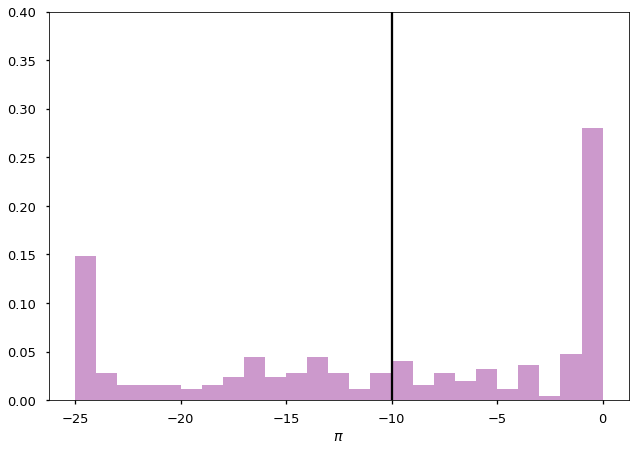

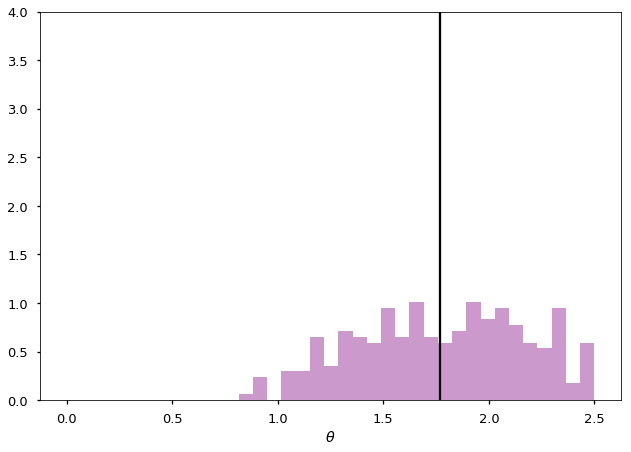

In [345]:
for name in ['phi', 'pi', 'theta']:
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(pd.Series([est[name] 
                                for est, cov in est_arr]).dropna(), ax=ax, color='purple', bins=25,
                     kde=False, norm_hist=True)
    diff = (bounds[name]['max'] - bounds[name]['min'])
    ax.set_xlim([bounds[name]['min'] - .05 * diff ,  bounds[name]['max'] + .05 * diff])

    ax.set_ylim([0, 10 / diff])
    ax.axvline(true_params[name], color='black')
        
    ax.set_xlabel(f"$\{name}$")

    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".tmp.pdf", frameon=False, pad_inches=0,
                bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [346]:
omega

{'gamma': 0.012573375574627142,
 'beta': 3.926575397336702,
 'psi': -3.696130178305947,
 'zeta': 0.7871100697385425,
 'log_both': -5.934467139179028,
 'log_scale': -5.551091089493258,
 'logit_rho': 1.2444515266481262}

In [347]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [348]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [349]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [350]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

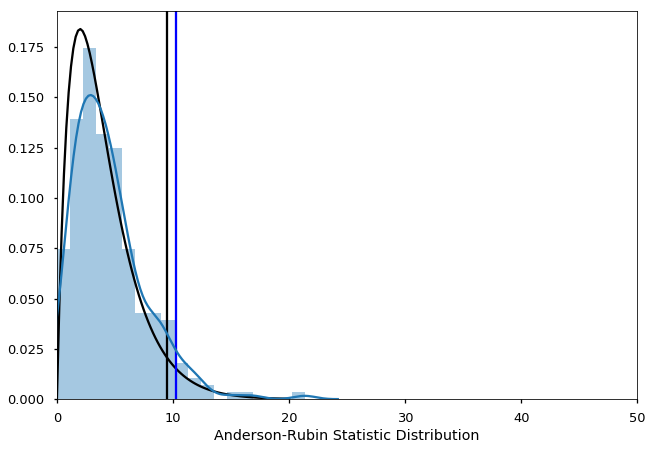

In [351]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 50)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')
    sns.distplot(ar_results, ax=ax)

In [352]:
np.mean(ar_results >= stats.chi2.ppf(df=4, q=.95))

0    0.072
dtype: float64

In [353]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [248]:
np.percentile(returnval.qlr_stat, 95)

8.638212491964953

In [249]:
true_params['phi']

-0.4

In [256]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

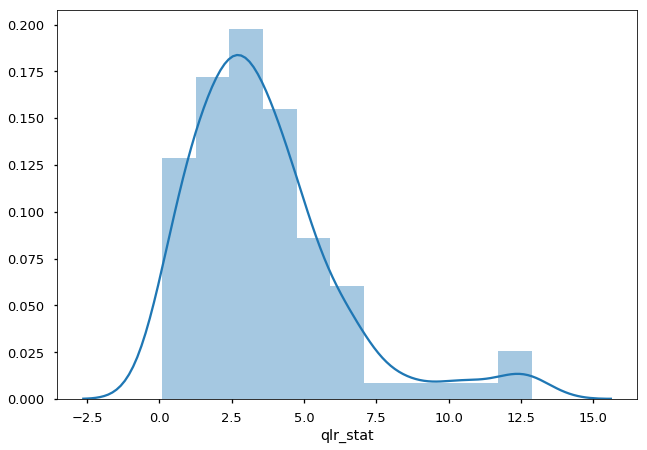

In [251]:
sns.distplot(returnval.qlr_stat)

In [252]:
returnval.head(500)

,qlr_stat,robust_qlr_qauntile,robust,standard
0,3.249479,8.512725,False,False
1,2.541104,8.512549,False,False
2,5.727943,8.512733,False,False
3,5.039720,8.512494,False,False
4,3.664762,8.512681,False,False
5,2.729228,8.512634,False,False
6,1.499189,8.512601,False,False
7,3.268081,8.512559,False,False
8,3.731879,9.487729,False,False
9,3.289582,9.487729,False,False


In [253]:
returnval.mean()

qlr_stat               3.600753
robust_qlr_qauntile    8.838952
robust                 0.050000
standard               0.070000
dtype: float64

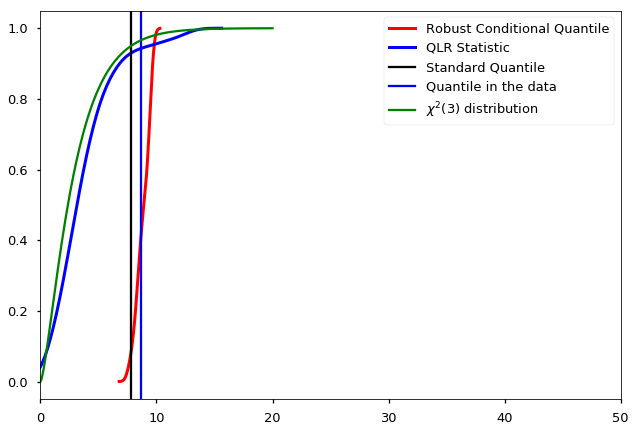

In [255]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)